<a href="https://colab.research.google.com/github/lucasdelimanogueira/Relational-partitioning-fuzzy-clustering-algorithms-based-on-multiple-dissimilarity-matrices/blob/main/Relational_partitioning_fuzzy_clustering_algorithms_based_on_multiple_dissimilarity_matrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relational partitioning fuzzy clustering algorithms based on
#multiple dissimilarity matrices

This was an implementation of the following scientific article:

https://drive.google.com/file/d/16FUgMxTfSYyMAhkFf0__W0enavNg_xet/view?usp=sharing

https://www.sciencedirect.com/science/article/abs/pii/S0165011412004216

### Libraries

In [ ]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import numpy as np
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KernelDensity
import scipy.special
from sklearn.metrics.cluster import contingency_matrix
import warnings
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from scipy.stats import friedmanchisquare
from scipy.stats import kde
import seaborn as sns

###Algorithm "Partitioning fuzzy K-medoids clustering algorithms with relevance weight for
###each dissimilarity matrix estimated locally"

#### Auxiliary functions

Adequacy Criterion
$J = \sum_{k=1}^{K}\sum_{i=1}^{n}(u_{ik})^mD_{(\lambda_k,s)}(e_i, G_k)$

In [ ]:
def get_adequacy_criterion(U, D_lamb, m):
  """Loss function to check the convergence stop criterion.
  It measures how much the G_k prototypes fits the elements e_i
  """

  K = D_lamb.shape[1]

  J = 0
  for k in range(K):
    J += ( U.T[k,:] ** m) @ D_lamb[:,k]

  return J

Algorithm to calculate the prototypes G_k

Prototype $G_k = G*$

$G* \leftarrow \emptyset$

REPEAT

&emsp;Encontrar $e_i \in E$, $e_i \notin G*$ em que $l = argmin_{1\leq{h}\leq{n}}\sum_{i=1}^{n}(u_{ik})^m\sum_{j=1}^{p}(\lambda_{kj})^sd(e_i,e_h)$

&emsp;$G* \leftarrow G*\cup\{e_i\}$

UNTIL $|G*| = q$



In [ ]:
def calculate_prototype(U, m, q, s, lamb, D):
  """Calculates the prototypes G_k of each cluster K, according to 2.3 proposition (article)"""
  Gk_indexes = [] # Indexes of the prototypes G_k
  K = U.shape[1] # Amount of clusters C_k
  n = U.shape[0] # Amount of elements e_i
  p = len(D) # Amount of dissimilarity matrices (views)

  for k in range(K):

    Gk = []
    L = np.zeros((1,n))
    for i in range(n):

      sum = np.zeros((1,n))
      for j in range(p):
        sum += ( lamb[k,j]**s )*D[j][i][:]

      L += ( U[i][k]**m ) * sum

    l = L.argsort()[0,:q]

    Gk_indexes.append(list(l))
    
  return Gk_indexes

Matching Function $D_{(\lambda_k,s)}(e_i, G_k) = \sum_{j=1}^{p}(\lambda_{kj})^s\sum_{e \in G_k}d_j(e_i,e)$

In [ ]:
def get_matching(Gk_indexes, lamb, s, D, q):
  """Calculates the match beteween an element e_i of an C_k cluster and a prototype G_K of the respective cluster 
  
  lamb -- weight matrices lamb_kj
  D -- dissimilarity matrices list
  
  """

  p = len(D) # Amount of dissimilarity matrices (views)
  K = len(Gk_indexes) # Amount of clusters C_k
  n = len(D[0][:,1]) # Amount of elements e_i

  D_lamb = np.zeros((n,K))


  for i in range(n):
    for k, Gk in enumerate(Gk_indexes):

      sum_j = 0
      for j in range(p):

        sum_Gk = 0
        for ek in Gk:
          sum_Gk += D[j][i][ek]

        sum_j +=  ( lamb[k][j]**s ) * sum_Gk

      D_lamb[i][k] = sum_j
          
  return D_lamb

Membership Degree $\textbf{U}=(\textbf{u}_1,...,\textbf{u}_n)$, where $\textbf{u}_i=(u_{i1},...,u_{iK})$, $(i=1,...,n)$, onde:
<br>
<br>
$u_{ik} = \left[\sum_{h=1}^{K}\left(\frac{D_{(\lambda_k,s)}(e_i,G_k)}{D_{(\lambda_h,s)}(e_i,G_h)}\right)^{1/(m-1)}\right]^{-1}$

In [ ]:
def calculate_membership_degree(m, D_lamb):
  """Calculates the membership degree between the u_ik of each element i 
  with respects to cluster k
  """
  
  n = D_lamb.shape[0]
  K = D_lamb.shape[1]

  U = np.zeros((n,K))

  for i in range(n):
    for k in range(K):
      sum = 0

      for h in range(K):
        if D_lamb[i][h] == 0:
          D_lamb[i][h] = 0.001 # avoids division by 0
        sum += ( D_lamb[i][k] / D_lamb[i][h] )**(1/(m-1))

      if sum == 0: # if e_i = G_k (itself -> distance = 0)
        U[i][k] = 1 # avoids division by 0
      else:
        U[i][k] = sum**(-1)


  return U

Relevance Weights $\lambda_k = (\lambda_{k1},...,\lambda_{kp})$, $(k=1,...,K)$, onde:
<br>
<br>
$\lambda_{kj} = \dfrac{\prod_{h=1}^{p}\left[\sum_{i=1}^{n}(u_{ik})^m\sum_{e \in G_k}d_h(e_i,e)\right]}{\left[\sum_{i=1}^{n}(u_{ik})^m\sum_{e \in G_k}d_j(e_i,e)\right]}$

In [ ]:
def calculate_weights(Gk_indexes, D, U, m):
  """Calculates the relevance weights lamb_kj of cluster k using each dissimilarity matrix j
  
  Gk_indexes -- Indexes of elements that are definedes as an prototype G_k
    Each G_K is an subset of cardinality q. Below we have an example with 3 clusters of cardinality 2
    ex: Gk_indexes = [[1, 3], [23, 12], [51,32]]. 
    -> 23 e 12 are the indexes of the elements (e[23], e[12]) which form the cluster 2 (second cluster)
  
  D -- dissimilarity matrices list
    ex: D = [dist_norm_fac, dist_norm_fou, dist_norm_kar]
  
  U -- Membership degree matrix of shape n x K, n is the amount of elements and K the amount of clusters
  
  """

  p = len(D)
  K = len(Gk_indexes)
   
  lamb = np.zeros((K,p)) # lambda matrix initialization

  for j in range(p): # for each dissimilarity matrix j
    for k, Gk in enumerate(Gk_indexes): # for each cluster k

      numerator = 1
      for h in range(p):
        sum = 0
        for i in range(len(U[:,k])):
          for ek in Gk:
            sum += ( U[i][k]**m ) * D[h][i][ek]
        numerator *= sum


      denominator = 0
      for i in range(len(U[:,k])):
        for ek in Gk:
          denominator += ( U[i][k]**m ) * D[j][i][ek]
          
      
      lamb[k][j] = ( numerator**(1/p) ) / denominator

  return lamb

#### Complete algorithm


In [ ]:
def MFCMdd_RWL_P(K, m, T, e, D, q, s):
  J_plot = []
  #### Step 0 - Initialization ####
  p = len(D) # Amount of dissimilarity matrices
  n = D[0].shape[0] # Amount of elements e_n

  #initial lambda_kj = 1
  lamb = np.ones((K,p))

  # samples randomly K prototypes G_k
  Gk_indexes = []
  for k in range(K):
    Gk = random.sample(range(1, n+1), q) # sampling without replacement of indexes values from 1 to n, q times (cardinality)
    Gk_indexes.append(Gk)

  # calculates D_lamb
  D_lamb = get_matching(Gk_indexes, lamb, s, D, q)

  # calculates U
  U = calculate_membership_degree(m, D_lamb)

  # calculates J
  J_0 = get_adequacy_criterion(U, D_lamb, m)
  
  for t in range(T):
    #### Step 1 - Calculation of the best prototypes ####
    Gk_indexes = calculate_prototype(U, m, q, s, lamb, D)

    #### Step 2 - Calculation of the best relevance weight vector ####
    lamb = calculate_weights(Gk_indexes, D, U, m)

    #### Step 3 - Definition of the best fuzzy partition ####
    D_lamb = get_matching(Gk_indexes, lamb, s, D, q)
    U = calculate_membership_degree(m, D_lamb)

    #### Step 4
    J_1 = get_adequacy_criterion(U, D_lamb, m)
    J_plot.append(J_1)

    if abs(J_1 - J_0) <= e:
      return U, J_plot, Gk_indexes

    J_0 = J_1

  return U, J_plot, Gk_indexes

#### Algorithm testing using a simple dataset to validation

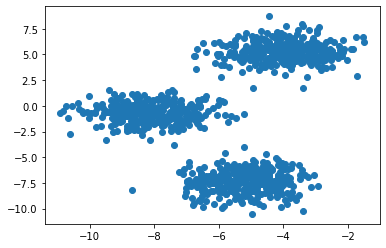

In [ ]:
from sklearn import datasets

# generating a random dataset
x,y = datasets.make_blobs(n_samples=1000, n_features = 2, centers=3, random_state=873) 
x1 = x[:,0]
x2 = x[:,1]

plt.scatter(x1, x2)
plt.show()

In [ ]:
# applying the algorithm

norm_x = preprocessing.normalize(x)
distancia_norm_x = pdist(norm_x, metric='euclidean')
VIEW_X = squareform(distancia_norm_x)

U, J_plot, Gk_indexes = MFCMdd_RWL_P(K=3, m=1.6, T=150, e=10**(-10), D=[VIEW_X], q=1, s=1)

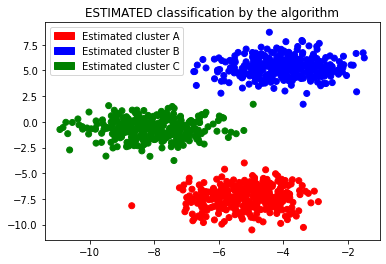

In [ ]:
# visualizing results

import matplotlib.patches as mpatches

df = pd.DataFrame(columns=['Index', 'Classe estimada'])

# classifies the element e_i with the index of cluster with the highest membership degree (transform fuzzy to crisp partitioning)-> np.argmax(membership_degree) -> 0, 1
for i, membership_degree  in enumerate(U):
  df_i = pd.DataFrame([[i, np.argmax(membership_degree)]], columns=['Index', 'Estimated cluster'])
  df = df.append(df_i, ignore_index=True)
df['Real class'] = y

# plot
df['Caracteristic X1'] = x[:,0]
df['Caracteristic X2'] = x[:,1]
colors = {0:'red', 1:'green', 2:'blue'}

plt.scatter(df['Caracteristic X1'], df['Caracteristic X2'], c=df['Estimated cluster'].apply(lambda x: colors[x]))

red_patch = mpatches.Patch(color='red', label='Estimated cluster A')
blue_patch = mpatches.Patch(color='blue', label='Estimated cluster B')
green_patch = mpatches.Patch(color='green', label='Estimated cluster C')
plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.title('ESTIMATED classification by the algorithm')

plt.show()

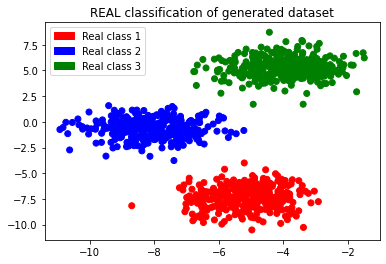

In [ ]:
# comparing clusters calculated with real classes

colors = {0:'green', 2:'blue', 1:'red'}
plt.scatter(df['Caracteristic X1'], df['Caracteristic X2'], c=df['Real class'].apply(lambda x: colors[x]))

red_patch = mpatches.Patch(color='red', label='Real class 1')
blue_patch = mpatches.Patch(color='blue', label='Real class 2')
green_patch = mpatches.Patch(color='green', label='Real class 3')
plt.legend(handles=[red_patch, blue_patch, green_patch])

plt.title('REAL classification of generated dataset')

plt.show()

As we can see, the calculated clusters approximates the real classes

In [ ]:
# Others metrics to evaluate the algorithm

n = U.shape[0]
Vpc = (1/n)*np.sum(U ** 2)
c = len(Gk_indexes)
mod_partition_coef = 1 - ( c/(c-1) )*( 1 - Vpc)
print('Modified Partition Coefficient:', mod_partition_coef,'\n\n')

############# partition entropy #############
n = U.shape[0]
Vpe = (-1/n)*np.sum(np.multiply(U, np.log(U)))
print('Partition Entropy:', Vpe,'\n\n')

########## crisp partition #############
crisp = np.zeros(U.shape)
for i in range(U.shape[0]):
  j = np.argmax(U[i][:])
  crisp[i][j] = 1
crisp

########## contigence matrix #########
labels_priori = list(df['Real class'])

labels_partition = []
for i in range(U.shape[0]):
  labels_partition.append(np.argmax(U[i][:]))

cm = contingency_matrix(labels_priori, labels_partition)


########## f-measure #########################
n = U.shape[0]
C = cm.shape[0]
K = cm.shape[1]

F_measure = 0
for j in range(K):
  M = []

  for i in range(C):
    n_ij = cm[i][j]
    n_i = np.sum(cm[i,:])
    n_j = np.sum(cm[:,j])

    if n_ij != 0: # avoids NaN values (division by 0 when n_ij = 0)
      M.append(( (n_ij/n_i)*(n_ij/n_j) ) / ( (n_ij/n_i) + (n_ij/n_j) ))
    else:
      M.append(0)

  max_i = max(M)
  F_measure += (n_j/n) * max_i
print('F-Measure:', F_measure,'\n\n\n')

########## adjusted rand index ##########
n = U.shape[0]
C = cm.shape[0]
K = cm.shape[1]

m = 0
for j in range(K):
  for i in range(C):
    n_ij = cm[i][j]
    m += scipy.special.comb(n_ij,2)

m_1 = 0
for i in range(C):
  n_i = np.sum(cm[i,:])
  m_1 += scipy.special.comb(n_i,2)

m_2 = 0
for j in range(K):
  n_j = np.sum(cm[:,j])
  m_2 += scipy.special.comb(n_j,2)

M = scipy.special.comb(n,2)

ARI = (m - (m_1*m_2)/M) / (m_1/2 + m_2/2 - (m_1*m_2)/M)
print('Adjusted Rand Index: ', ARI,'\n\n\n')

Modified Partition Coefficient: 0.8678234749632807 


Partition Entropy: 0.19344616152232294 


F-Measure: 0.49950000000000006 



Adjusted Rand Index:  0.996996990984967 





#### Testing the algorithm in an more complex dataset https://archive.ics.uci.edu/ml/datasets/Multiple+Features

This dataset consists of features of handwritten numerals (`0'--`9') extracted from a collection of Dutch utility maps. 200 patterns per class (for a total of 2,000 patterns) have been digitized in binary images. These digits are represented in terms of the following six feature sets (files): 


In [ ]:
#datasets
mfeat_fac = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mfeat/mfeat-fac", delim_whitespace=True, header=None)
mfeat_fou = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mfeat/mfeat-fou", delim_whitespace=True, header=None)
mfeat_kar = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mfeat/mfeat-kar", delim_whitespace=True, header=None)
mfeat_pix = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mfeat/mfeat-pix", delim_whitespace=True, header=None)
mfeat_zer = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mfeat/mfeat-zer", delim_whitespace=True, header=None)
mfeat_mor = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mfeat/mfeat-mor", delim_whitespace=True, header=None)

Normalize the data and calculate three dissimilarity matrices (one for each dataset)
mfeat-fac (VIEW1), mfeat-fou (VIEW2), mfeat-kar (VIEW3)) using Euclidian distance

In [ ]:
# normalize data
norm_fac = preprocessing.normalize(mfeat_fac)
norm_fou = preprocessing.normalize(mfeat_fou)
norm_kar = preprocessing.normalize(mfeat_kar)

# compute dissimilarity matrices using euclidian distance
distancia_norm_fac = pdist(norm_fac, metric='euclidean')
distancia_norm_fou = pdist(norm_fou, metric='euclidean')
distancia_norm_kar = pdist(norm_kar, metric='euclidean')

# the 'pdist' return an numpy.array with n * (n - 1) / 2 elements. 
# to turn it into numpy.array with dimension n x n we can use 'squareform'.
VIEW1 = squareform(distancia_norm_fac)
VIEW2 = squareform(distancia_norm_fou)
VIEW3 = squareform(distancia_norm_kar)


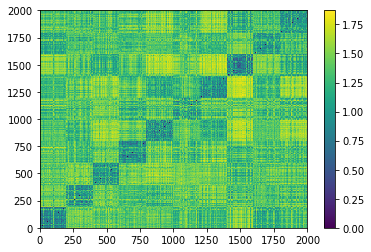

In [ ]:
"""
plt.pcolormesh(VIEW1)
plt.colorbar()
plt.show()

plt.pcolormesh(VIEW2)
plt.colorbar()
plt.show()
"""
plt.pcolormesh(VIEW3)
plt.colorbar()
plt.show()

According to the datasets website, the data are ordered in their respective classes in groups of 200 rows for each class. Observing the above plot, one can identify on the diagonal 10 low dissimilarity regions, which indicates to be the 10 clusters, confirming the website info (It just happens because the datasets rows are ordered per class).

##### Executing the algorithm 5 times, using the 3 dissimilarity matrices (D=[VIEW1, VIEW2, VIEW3]), to obtain a fuzzy partitioning of 10 clusters and selects the best result according to the loss functionons

In [ ]:
class Partition:
  def __init__(self, D):
    self.U = 0
    self.J_plot = 0
    self.Gk_indexes = 0
    self.D = D

  def get_best_partition(self, trials):
    """ Executes the algorithm 'trials' times and return the best partitioning"""
    
    for i in range(trials):
      best_J = 0

      # runs the algorithm 'trials' times
      U, J_plot, Gk_indexes = MFCMdd_RWL_P(K=10, m=1.6, T=150, e=10**(-10), D=self.D, q=1, s=1)

      # at the first iteration, consider all results the best
      if i == 0:
        best_J = J_plot[-1]
        self.U = U
        self.J_plot = J_plot
        self.Gk_indexes = Gk_indexes
      
      # if at the next iterations the J decreses, update the results
      if J_plot[-1] < best_J:
        self = J_plot[-1]
        self.U = U
        self.J_plot = J_plot
        self.Gk_indexes = Gk_indexes
    
  def get_results(self):
    #### modified partition coefficient #####
    n = self.U.shape[0]
    Vpc = (1/n)*np.sum(self.U ** 2)
    c = len(self.Gk_indexes)
    self.mod_partition_coef = 1 - ( c/(c-1) )*( 1 - Vpc)
    print('Modified Partition Coefficient:', self.mod_partition_coef,'\n\n\n')

    #########################################

    #### partition entropy ####
    n = self.U.shape[0]
    self.Vpe = (-1/n)*np.sum(np.multiply(self.U, np.log(self.U)))
    print('Partition Entropy:', self.Vpe,'\n\n\n')

    #########################################

    #### crisp partition ###################
    self.crisp = np.zeros(self.U.shape)
    for i in range(self.U.shape[0]):
      j = np.argmax(self.U[i][:])
      self.crisp[i][j] = 1
    self.crisp

    #########################################

    #### contingence matrix ################
    labels_priori = []
    for i in range(10):
      labels_priori += 200*[i]

    labels_partition = []
    for i in range(self.U.shape[0]):
      labels_partition.append(np.argmax(self.U[i][:]))

    self.contingency_matrix = contingency_matrix(labels_priori, labels_partition)


    ########################################

    #### f-measure #########################
    n = self.U.shape[0]
    C = self.contingency_matrix.shape[0]
    K = self.contingency_matrix.shape[1]

    self.F_measure = 0
    for j in range(K):
      M = []

      for i in range(C):
        n_ij = self.contingency_matrix[i][j]
        n_i = np.sum(self.contingency_matrix[i,:])
        n_j = np.sum(self.contingency_matrix[:,j])

        if n_ij != 0: # avoids NaN values (division by 0 when n_ij = 0)
          M.append(( (n_ij/n_i)*(n_ij/n_j) ) / ( (n_ij/n_i) + (n_ij/n_j) ))
        else:
          M.append(0)

      max_i = max(M)
      self.F_measure += (n_j/n) * max_i
    print('F-Measure:', self.F_measure,'\n\n\n')

    ###########################################

    #### Adjusted Rand Index ##################
    n = self.U.shape[0]
    C = self.contingency_matrix.shape[0]
    K = self.contingency_matrix.shape[1]

    m = 0
    for j in range(K):
      for i in range(C):
        n_ij = self.contingency_matrix[i][j]
        m += scipy.special.comb(n_ij,2)

    m_1 = 0
    for i in range(C):
      n_i = np.sum(self.contingency_matrix[i,:])
      m_1 += scipy.special.comb(n_i,2)

    m_2 = 0
    for j in range(K):
      n_j = np.sum(self.contingency_matrix[:,j])
      m_2 += scipy.special.comb(n_j,2)

    M = scipy.special.comb(n,2)

    self.ARI = (m - (m_1*m_2)/M) / (m_1/2 + m_2/2 - (m_1*m_2)/M)
    print('Adjusted Rand Index: ', self.ARI,'\n\n\n')



partition_VIEW123 = Partition(D = [VIEW1, VIEW2, VIEW3])
partition_VIEW123.get_best_partition(trials=5)
partition_VIEW123.get_results()

Modified Partition Coefficient: 0.01526006103327826 



Partition Entropy: 2.24964894386586 



F-Measure: 0.3297158724250197 



Adjusted Rand Index:  0.4795154022056333 





Some analysis regarding the results:
The Modified Partition Coefficient (MPC) is very low, indicating that the partitions are not adjusting very well with the data

However, observing the original dataset, one can verify that there is a high sobreposition between the classes, justifying the low MPC.




### Ensemble classification
As part of homework of machine learning discipline, it was asked to use the crisp partitioning to label the elements and train some classifiers using ensembles

In [ ]:
# Transforming the fuzzy partitions to crisp partitions
classes_list = list(np.argmax(partition_VIEW123.U, axis=1))

# Using the partitions as class labels

# VIEW1
view1 = pd.DataFrame(norm_fac)
view1['Class'] = classes_list

# VIEW2
view2 = pd.DataFrame(norm_fou)
view2['Class'] = classes_list

# VIEW3
view3 = pd.DataFrame(norm_kar)
view3['Class'] = classes_list

#### Combine classifier with sum method

In [ ]:
class combined_classifier:
  def __init__(self):
    self.accuracy_list = []

  def cross_validate(self, classifier_1, classifier_2, classifier_3, df_view1, df_view2, df_view3):
    """Combine 3 classifiers with the sum method and runs 30 cross-validations with 10-folds training each classifier with its respective view (dataset) """
    
    # separate variables and classes
    view1_x = np.array( df_view1.drop('Class', axis=1) )
    view1_y = np.array( df_view1['Class'] )

    view2_x = np.array( df_view2.drop('Class', axis=1) )
    view2_y = np.array( df_view2['Class'] )

    view3_x = np.array( df_view3.drop('Class', axis=1) )
    view3_y = np.array( df_view3['Class'] )

    #30 times
    for i in range(30):

      #10 folds
      skf = StratifiedKFold(n_splits=10, shuffle=True)

      successes = 0
      total = 0

      for train_index, test_index in skf.split(view1_x, view1_y):
        """Para cada fold"""

        #trains classifier 1 with dataset view1
        classifier_1.fit(view1_x[train_index], view1_y[train_index])

        #trains classifier 2 with dataset view2
        classifier_2.fit(view2_x[train_index], view2_y[train_index])

        #trains classifier 3 with dataset view3
        classifier_3.fit(view3_x[train_index], view3_y[train_index])

        for i in test_index:
          """For each test example of the fold"""
          #returns array with posteriori probabilities of each class (classifier 1 with view1)
          p1 = classifier_1.predict_proba(view1_x[i][:].reshape(1,view1_x.shape[1]))

          #returns array with posteriori probabilities of each class (classifier 2 with view2)
          p2 = classifier_2.predict_proba(view2_x[i][:].reshape(1,view2_x.shape[1]))

          #returns array with posteriori probabilities of each class (classifier 3 with view3)
          p3 = classifier_3.predict_proba(view3_x[i][:].reshape(1,view3_x.shape[1]))

          #sum rule
          best_index = np.argmax(p1+p2+p3) # class index with highest probabilities overall sum
          best_class = classifier_1.classes_[best_index] # class with highest probabilities overall sum

          # if get it right
          if best_class == view1_y[i]:
            successes += 1
          total += 1
        
        accuracy = successes/total
        self.accuracy_list.append(accuracy)



#### Ensemble 1 - Combining 3 Bayesian Gaussian.

In [ ]:
warnings.simplefilter("ignore", UserWarning)

# creates the 3 bayesian classifiers
gauss_view1 = GaussianNB()
gauss_view2 = GaussianNB()
gauss_view3 = GaussianNB()

# combines the bayesian classifiers
combined_gauss = combined_classifier()
combined_gauss.cross_validate(gauss_view1, gauss_view2, gauss_view3, view1, view2, view3)

##### Plotting results.

Mean accuracy (95% conf): 0.8347 +- 0.0222



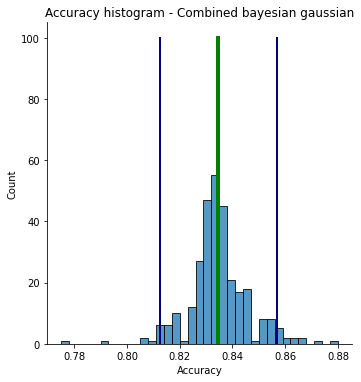

In [ ]:
mu = np.mean(combined_gauss.accuracy_list)
sigma = np.std(combined_gauss.accuracy_list)

print(f'Mean accuracy (95% conf): {mu:.4f} +- {1.96*sigma:.4f}\n')

# plot
sns.displot(combined_gauss.accuracy_list)
plt.xlabel('Accuracy')
plt.title('Accuracy histogram - Combined bayesian gaussian')

# mean and confidence interval
plt.plot([mu,mu],[0, 100], 'k-', lw=4, color='green')
plt.plot([mu-(1.96*sigma),mu-(1.96*sigma)],[0, 100], 'k-', lw=2, color='navy')
plt.plot([mu+(1.96*sigma),mu+(1.96*sigma)],[0, 100], 'k-', lw=2, color='navy')

plt.show()

#### Ensemble 2 - Combining 3 K-NN.

In [ ]:
warnings.simplefilter("ignore", UserWarning)

# creates the 3 K-NN classifiers
knn_view1 = KNeighborsClassifier(weights='distance')
knn_view2 = KNeighborsClassifier(weights='distance')
knn_view3 = KNeighborsClassifier(weights='distance')

In [ ]:
# searching for the best K value using grid search
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.split(view1.drop('Class', axis=1),view1['Class'])

k_list = list(range(1,30))
parameters = dict(n_neighbors=k_list)

grid1 = GridSearchCV(knn_view1, parameters, cv=skf, scoring='accuracy')
grid1.fit(view1.drop('Class', axis=1),view1['Class'])
print(f"Best parameter {grid1.best_params_} ; Accuracy** {grid1.best_score_} ")

grid2 = GridSearchCV(knn_view2, parameters, cv=skf, scoring='accuracy')
grid2.fit(view2.drop('Class', axis=1),view2['Class'])
print(f"Best parameter {grid2.best_params_} ; Accuracy** {grid2.best_score_} ")

grid3 = GridSearchCV(knn_view3, parameters, cv=skf, scoring='accuracy')
grid3.fit(view3.drop('Class', axis=1),view3['Class'])
print(f"Best parameter {grid3.best_params_} ; Accuracy** {grid3.best_score_} ")


Best parameter {'n_neighbors': 6} ; Accuracy** 0.8494999999999999 
Best parameter {'n_neighbors': 19} ; Accuracy** 0.6975 
Best parameter {'n_neighbors': 8} ; Accuracy** 0.8494999999999999 


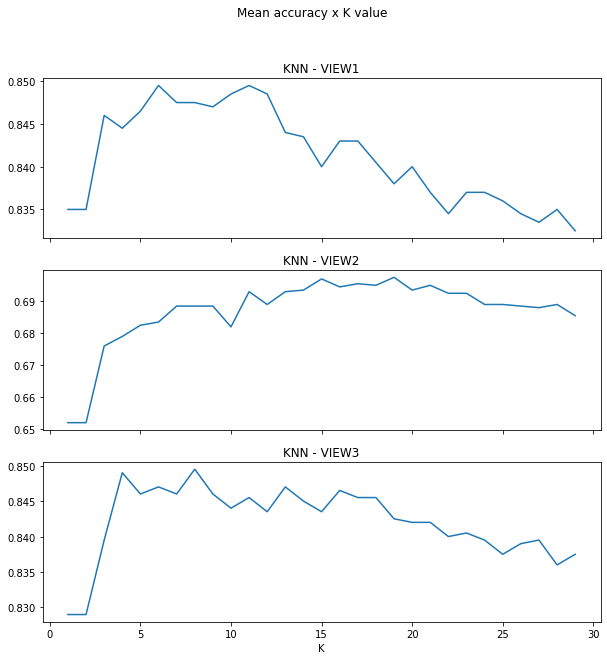

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10,10))

fig.suptitle('Mean accuracy x K value')
ax1.plot(k_list, grid1.cv_results_['mean_test_score'])
ax1.set_title("KNN - VIEW1")

ax2.plot(k_list, grid2.cv_results_['mean_test_score'])
ax2.set_title("KNN - VIEW2")

ax3.plot(k_list, grid3.cv_results_['mean_test_score'])
ax3.set_title("KNN - VIEW3")

ax3.set_xlabel("K")
plt.show()


In [ ]:
# Training and assemblying the classifiers with its respectives bests K values
warnings.simplefilter("ignore", UserWarning)

best_k1 = list(grid1.best_params_.values())[0]
best_k2 = list(grid2.best_params_.values())[0]
best_k3 = list(grid3.best_params_.values())[0]

# creates 3 k-NN classifiers with the best values of K
knn_view1 = KNeighborsClassifier(n_neighbors=best_k1, weights='distance')
knn_view2 = KNeighborsClassifier(n_neighbors=best_k2, weights='distance')
knn_view3 = KNeighborsClassifier(n_neighbors=best_k3, weights='distance')

# Combines the 3 classifiers
combined_knn = combined_classifier()
combined_knn.cross_validate(knn_view1, knn_view2, knn_view3, view1, view2, view3)

##### Plotting results

Mean accuracy (95% conf): 0.8687 +- 0.0169



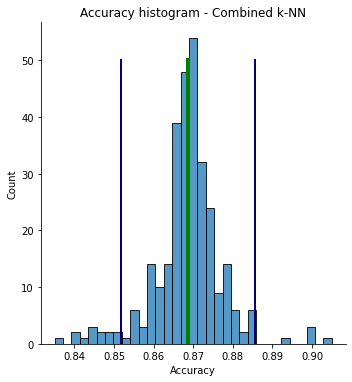

In [ ]:
mu = np.mean(combined_knn.accuracy_list)
sigma = np.std(combined_knn.accuracy_list)

print(f'Mean accuracy (95% conf): {mu:.4f} +- {1.96*sigma:.4f}\n')

# plot
sns.displot(combined_knn.accuracy_list)
plt.xlabel('Accuracy')
plt.title('Accuracy histogram - Combined k-NN')

# mean and confidence interval
plt.plot([mu,mu],[0, 50], 'k-', lw=4, color='green')
plt.plot([mu-(1.96*sigma),mu-(1.96*sigma)],[0, 50], 'k-', lw=2, color='navy')
plt.plot([mu+(1.96*sigma),mu+(1.96*sigma)],[0, 50], 'k-', lw=2, color='navy')

plt.show()

#### Ensemble 3 - Combining 3 Parzen window bayesian classifier.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=0.1, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [ ]:
warnings.simplefilter("ignore", UserWarning)

# creates the 3 parzen window classifiers
parzen_view1 = KDEClassifier()
parzen_view2 = KDEClassifier()
parzen_view3 = KDEClassifier()

In [ ]:
# searching for the best h value with grid search
warnings.filterwarnings('ignore')

skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.split(view1.drop('Class', axis=1),view1['Class'])

parzen_list = np.linspace(0, 1, 100)
paratemeters_pw = dict(bandwidth=parzen_list)

grid1 = GridSearchCV(parzen_view1, paratemeters_pw, cv=skf, scoring='accuracy')
grid1.fit(view1.drop('Class', axis=1),view1['Class'])
print(f"Best parameter {grid1.best_params_} ; Accuracy** {grid1.best_score_} ")

grid2 = GridSearchCV(parzen_view2, paratemeters_pw, cv=skf, scoring='accuracy')
grid2.fit(view2.drop('Class', axis=1),view2['Class'])
print(f"Best parameter {grid2.best_params_} ; Accuracy** {grid2.best_score_} ")

grid3 = GridSearchCV(parzen_view3, paratemeters_pw, cv=skf, scoring='accuracy')
grid3.fit(view3.drop('Class', axis=1),view3['Class'])
print(f"Best parameter {grid3.best_params_} ; Accuracy** {grid3.best_score_} ")


Best parameter {'bandwidth': 0.020202020202020204} ; Accuracy** 0.8495000000000001 
Best parameter {'bandwidth': 0.11111111111111112} ; Accuracy** 0.6900000000000001 
Best parameter {'bandwidth': 0.22222222222222224} ; Accuracy** 0.8539999999999999 


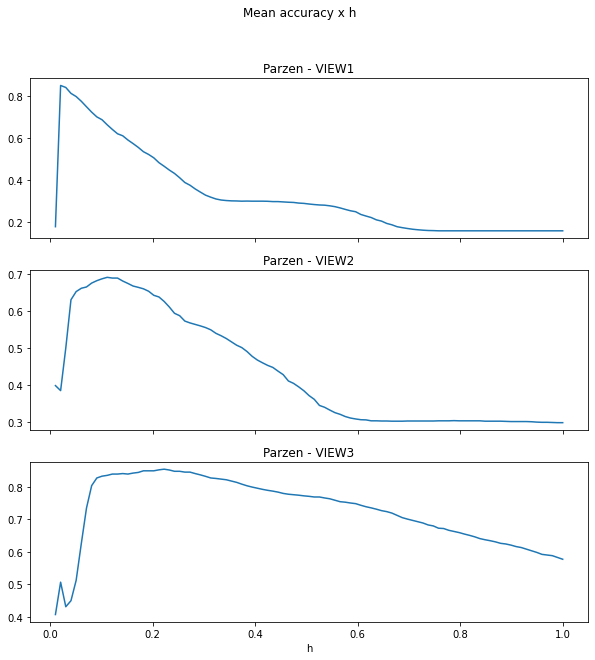

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10,10))

fig.suptitle('Mean accuracy x h')
ax1.plot(parzen_list, grid1.cv_results_['mean_test_score'])
ax1.set_title("Parzen - VIEW1")

ax2.plot(parzen_list, grid2.cv_results_['mean_test_score'])
ax2.set_title("Parzen - VIEW2")

ax3.plot(parzen_list, grid3.cv_results_['mean_test_score'])
ax3.set_title("Parzen - VIEW3")

ax3.set_xlabel("h")
plt.show()

In [ ]:
# Training and assemblying the classifiers with its respectives bests h values
warnings.simplefilter("ignore", UserWarning)

best_h1 = list(grid1.best_params_.values())[0]
best_h2 = list(grid2.best_params_.values())[0]
best_h3 = list(grid3.best_params_.values())[0]

# cria os 3 classificadores bayesianos parzen
parzen_view1 = KDEClassifier(bandwidth=0.02)
parzen_view2 = KDEClassifier(bandwidth=0.10)
parzen_view3 = KDEClassifier(bandwidth=0.20)

# classificador bayesiano parzen combinado
combined_parzen = combined_classifier()
combined_parzen.cross_validate(parzen_view1, parzen_view2, parzen_view3, view1, view2, view3)

##### Plotting results

Mean accuracy (95% conf): 0.8725 +- 0.0216



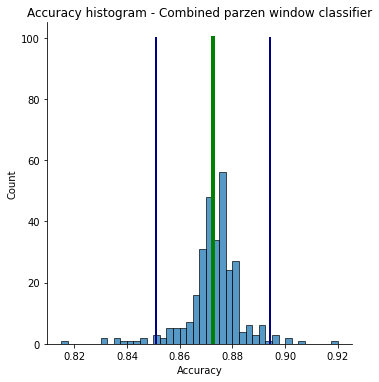

In [ ]:
mu = np.mean(combined_parzen.accuracy_list)
sigma = np.std(combined_parzen.accuracy_list)

print(f'Mean accuracy (95% conf): {mu:.4f} +- {1.96*sigma:.4f}\n')

# plot
sns.displot(combined_parzen.accuracy_list)
plt.xlabel('Accuracy')
plt.title('Accuracy histogram - Combined parzen window classifier')

# mean and confidence interval
plt.plot([mu,mu],[0, 100], 'k-', lw=4, color='green')
plt.plot([mu-(1.96*sigma),mu-(1.96*sigma)],[0, 100], 'k-', lw=2, color='navy')
plt.plot([mu+(1.96*sigma),mu+(1.96*sigma)],[0, 100], 'k-', lw=2, color='navy')

plt.show()

#### Comparing classifiers with statistics

##### Friedman Test

In [ ]:
# compare samples 
stat, p = friedmanchisquare(combined_gauss.accuracy_list, combined_knn.accuracy_list, combined_parzen.accuracy_list)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=437.609, p=0.000
Different distributions (reject H0)


As we had different distributions (H0 rejected), is worth to perform a perwise evaluation of the classifiers. First let us analyse the normality of the distributions to choose an adequate hypothesis test 

##### Normality test - Shapiro-Wilk


In [ ]:
p_gauss = stats.shapiro(combined_gauss.accuracy_list)[1]
p_knn = stats.shapiro(combined_knn.accuracy_list)[1]
p_parzen = stats.shapiro(combined_parzen.accuracy_list)[1]

alpha = 0.05

if p_gauss > alpha:
  print(f'GAUSS\np-value: {p_gauss}\nPara α = 0.05, fail to reject normality\n\n')
else:
  print(f'GAUSS\np-value: {p_gauss}\nPara α = 0.05, reject normality\n\n')

if p_knn > alpha:
  print(f'KNN\np-value: {p_knn}\nPara α = 0.05, fail to reject normality\n\n')
else:
  print(f'KNN\np-value: {p_knn}\nPara α = 0.05, reject normality\n\n')

if p_parzen > alpha:
  print(f'PARZEN\np-value: {p_parzen}\nPara α = 0.05, fail to reject normality\n\n')
else:
  print(f'PARZEN\np-value: {p_parzen}\nPara α = 0.05, eject normality\n\n')


GAUSS
p-value: 3.668804982037699e-10
Para α = 0.05, reject normality


KNN
p-value: 1.0439130462835955e-11
Para α = 0.05, reject normality


PARZEN
p-value: 2.920855221642642e-14
Para α = 0.05, eject normality




##### QQ Plots

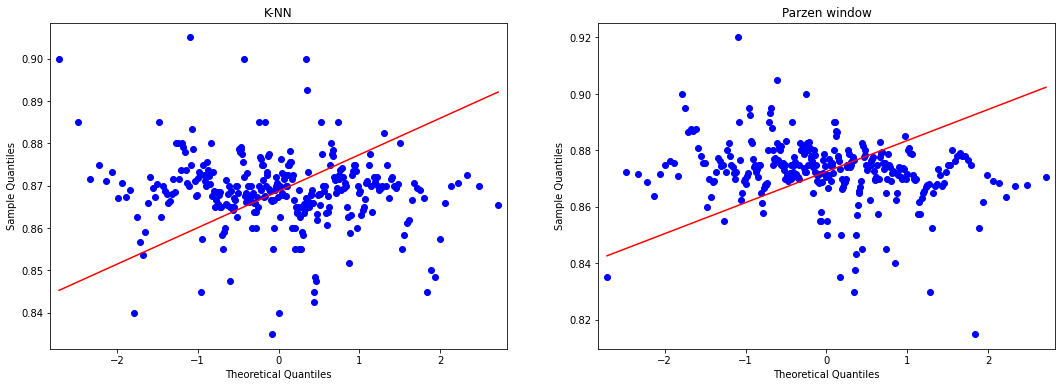

In [ ]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(18,6))

sm.qqplot(pd.DataFrame( combined_knn.accuracy_list ), line='s', ax=ax2)

sm.qqplot(pd.DataFrame( combined_parzen.accuracy_list ), line='s', ax=ax3)

ax2.set_title("K-NN")
ax3.set_title("Parzen window")

plt.show()

As the normality was reject for both distributions, we should use non-parametric hypothesis tests, for example Mann-Whitney U-test 

##### Mann-whitney test

Comparing only the 2 best classifiers (KNN and Parzen), because the mean accuracy of the gaussian combined-classifier got considerably low

In [ ]:
u_statistic, p_value = stats.mannwhitneyu(combined_knn.accuracy_list, combined_parzen.accuracy_list)
print(f'U: {u_statistic}\n')
print(f'p-value: {p_value:.3f}\n\n')

if p_value > 2*alpha:
  print('For α = 0.05, we accept the null hypothesis H0a\n\n')
  print('Conclusion: For α = 0.05, we do not have considerable evidence to support the difference between both classifiers')

else:
  print('For α = 0.05, we reject the null hypothesis H0\n\n')
  print('Conclusion: For α = 0.05, there is considerable evidence to support the superiority of the parzen window based classifier over the K-NN based classifier')



U: 29585.0

p-value: 0.000


For α = 0.05, we reject the null hypothesis H0


Conclusion: For α = 0.05, there is considerable evidence to support the superiority of the parzen window based classifier over the K-NN based classifier
